In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kubo_lib2 import *
import time

# Test velocity operators

In [ ]:
# Define the system
Lx = 6
Ly = 3
sample = 3
dims = [Lx, Ly, 4]
dV = 0.1

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=True)

xx,yy,oo = 1,1,3
vec = np.zeros(dims, dtype=complex)
vec[xx,yy,oo] = 1
print(vec)

vec_lin = linearize(kub,vec)
new_vec = kub.H0@vec_lin
final = de_linearize(kub, new_vec)
print(final)

# Test 1D TB chain

In [ ]:
kub = kubo()

Lx = 8
sample = 2
dV = 0.01
SCALE = 2.1
kub.set_1DTB(Lx,sample,dV, SCALE=SCALE)


mu = 1.7
TMIN = 0; TMAX = 10; NT = 30
tlist = np.linspace(TMIN, TMAX, NT)

print("kubo bond")
cond_bond = np.zeros(NT)
for xx in range(kub.lead1, kub.lead2-1):
    print("xx", xx)
    site_i = [xx, 0,0]
    site_j = [xx+1, 0,0]

    cond = kub.kubo_bond(tlist, mu, site_i, site_j)/dV
    cond_bond += np.real(cond)

cond2 = kub.kubotime_sample(tlist, mu)/dV
plt.plot(tlist, cond_bond,'--') 
plt.plot(tlist, np.real(cond2))
# plt.plot(tlist, np.imag(cond2))
# kub.test_tevop()
# kub.test_fermi_op()
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].matshow(np.real(kub.H0))
axs[0,1].matshow(np.real(kub.H))
axs[1,0].matshow(np.imag(kub.Vx))
plt.show()

In [ ]:
mu = 0.1
TMIN = 0; TMAX = 10; NT = 100
tlist = np.linspace(TMIN, TMAX, NT)

cond = kub.kubotime_sample(tlist, mu)/dV

# Kubo formula comparison


Comparing two different ways to obtain the Kubo formula with exact operators
1. sum over bonds using diagonalization (kubo_bond)
2. sum over sites using diagonalization (kubotime_sample)



All these methods begin with a diagonalization before using the kubo formula, so this is the complexity bottleneck. W: width, L: length, N: L\*W. Complexity: 
1. N³ + 3\*NT\*NB*\N²
2. N³ + 3\*NT\*NS*\N²
3. N³ + 3\*NT\*NR*\N²

for large NS, NR can be small

In [ ]:
# Define the system
Lx = 16
Ly = 2
sample = 2
dV = 0.1

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=True)

# Define the Fermi energy and the time series
mu = 0.6
TMIN = 0; TMAX = 30; NT = 80; tlist = np.linspace(TMIN, TMAX, NT)

# Define all the bonds across which you want to compute the current
vels = []
for xx in range(kub.lead1, kub.lead2):
    for yy in range(kub.Ly):
        vels.append([xx,yy,0,xx,yy,1])
        vels.append([xx,yy,1,xx,yy,2])
        vels.append([xx,yy,2,xx,yy,3])
    for yy in range(kub.Ly - 1):
        vels.append([xx,yy,2,xx,yy+1,1])

for xx in range(kub.lead1, kub.lead2-1):
    for yy in range(kub.Ly):
        vels.append([xx,yy,3,xx+1,yy,0])
    for yy in range(kub.Ly-1):
        vels.append([xx,yy,3,xx+1,yy+1,0])
print("total number of bonds: ", len(vels))

In [ ]:
axis = 2
print("Calculating Kubo with sum over bonds (kubo_bond)")
cond_bond = np.zeros(NT)
for vel in vels:
    site_i = vel[:3]
    site_j = vel[3:]
    cond = kub.kubo_bond(tlist, mu, site_i, site_j, axis)/dV
    cond_bond += np.real(cond)

print("Calculating Kubo with sum over sites INSIDE the sample (kubo_sample)")
cond2 = np.real(kub.kubotime_sample(tlist, mu, axis)/dV)

plt.plot(tlist, cond2)
plt.plot(tlist, cond_bond)

# Kubo with random vectors

Average value of the current operator as a function of time as calculated with random vectors instead of a sum over sites inside the sample. I'm using four different ways to generate the random vectors.
1. Calculate the current with a complex vector with random unit complex numbers
2. Same as before but subtract the value at t=0
3. Using the real part of the random vector in 1
4. Uniform distribution with variance 1

Case 1 yields a giant variance because a complex vector has a nonzero current. On average, this still provides the correct value, but we know that at t=0 it has to be zero. Case 2 enforces this, and induces a much smaller variance. Case 3 and 4 use real vectors instead.

In [ ]:
# Define the system
Lx = 16
Ly = 2
sample = 2
dV = 0.1

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=True)

# Define the Fermi energy and the time series
mu = 0.6
TMIN = 0; TMAX = 300; NT = 200; tlist = np.linspace(TMIN, TMAX, NT)

axis = 0
print("Calculating Kubo with sum over sites INSIDE the sample (kubo_sample)")
cond_exact = np.real(kub.kubotime_sample(tlist, mu, axis)/dV)

print("Calculating Kubo with random vectors (kubo_random)")
NR = 200
cond_R1 = np.real(kub.kubotime_random(tlist, mu, NR, axis,0)/dV)
cond_R2 = cond_R1 - cond_R1[0]
cond_R3 = np.real(kub.kubotime_random(tlist, mu, NR, axis,1)/dV)
cond_R4 = np.real(kub.kubotime_random(tlist, mu, NR, axis,2)/dV)



In [ ]:
# Perform the statistics. Subtracting the first point in the time series
# greatly reduces the statistical fluctuations
cond_av1 = np.mean(cond_R1, axis=1)
cond_av2 = np.mean(cond_R2, axis=1)
cond_av3 = np.mean(cond_R3, axis=1)
cond_av4 = np.mean(cond_R4, axis=1)

cond_std1 = np.std(cond_R1, axis=1)
cond_std2 = np.std(cond_R2, axis=1)
cond_std3 = np.std(cond_R3, axis=1)
cond_std4 = np.std(cond_R4, axis=1)

error_bar1 = cond_std1/np.sqrt(NR)
error_bar2 = cond_std2/np.sqrt(NR)
error_bar3 = cond_std3/np.sqrt(NR)
error_bar4 = cond_std4/np.sqrt(NR)

## Visual representation of the test

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(12,4))
for i in range(NR):
    axs[0].plot(tlist, np.real(cond_R1[:,i]))
    axs[1].plot(tlist, np.real(cond_R1[:,i] - cond_R1[0,i]))
    axs[2].plot(tlist, np.real(cond_R2[:,i]))
    axs[3].plot(tlist, np.real(cond_R3[:,i]))
    
axs[0].set_title("complex exp")
axs[1].set_title("complex exp - J(0)")
axs[2].set_title("real cos")
axs[3].set_title("real uniform")
plt.show()



# plots
fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].set_title("Averages")
axs[0].plot(tlist, cond_exact, 'k--', label="exact", linewidth=3)
axs[0].plot(tlist, cond_av2, label="random exp - J(0)") 
axs[0].plot(tlist, cond_av3, label="random cos")
axs[0].plot(tlist, cond_av4, label="random uniform")
axs[0].legend()

axs[1].set_title("Difference of averages from exact")
axs[1].plot(tlist, cond_av2-cond_exact, label="random exp - J(0)") 
axs[1].plot(tlist, cond_av3-cond_exact, label="random cos")
axs[1].plot(tlist, cond_av4-cond_exact, label="random uniform")
axs[1].legend()


# standard deviation
axs[2].set_title("std dev")
axs[2].plot(tlist, cond_std2, label="random exp - J(0)") 
axs[2].plot(tlist, cond_std3, label="random cos")
axs[2].plot(tlist, cond_std4, label="random uniform")
axs[2].legend()
plt.show()



In [ ]:
# Turn the test into a number that can be validated

soma1 = np.sum(np.abs(cond_av1-cond_exact)**2)
soma2 = np.sum(np.abs(cond_av2-cond_exact)**2)
soma3 = np.sum(np.abs(cond_av3-cond_exact)**2)
soma4 = np.sum(np.abs(cond_av4-cond_exact)**2)

print(f"phase      {soma1:2.2f} ~ 10000")
print(f"phase-J(0) {soma2:2.2f} ~ 9")
print(f"cos        {soma3:2.2f} ~ 2")
print(f"uniform    {soma4:2.2f} ~ 5")

# Current across width at different lengths
For each cross section, the current must be the same, so now I'm going to test this

In [ ]:
# Define the system
Lx = 64
Ly = 2
sample = 2
dV = 0.1

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=True)

# Define the Fermi energy and the time series
mu = 0.6
TMIN = 0; TMAX = 40; NT = 10; tlist = np.linspace(TMIN, TMAX, NT)


vels_set = []
# across bonds 0 and 1
for xx in range(kub.lead1, kub.lead2):
    vels = [[xx,yy,0,xx,yy,1] for yy in range(kub.Ly)]
    vels_set.append(vels)

# across bonds 2 and 3
for xx in range(kub.lead1, kub.lead2):
    vels = [[xx,yy,2,xx,yy,3] for yy in range(kub.Ly)]
    vels_set.append(vels)
    
# across bonds 1 and 2
for xx in range(kub.lead1, kub.lead2):
    vels1 = [[xx,yy,1,xx,yy,2] for yy in range(kub.Ly)]
    vels2 = [[xx,yy,1,xx,yy-1,2] for yy in range(1,kub.Ly)]
    vels = vels1+vels2    
    vels_set.append(vels)

# across bonds 3 and 0
for xx in range(kub.lead1, kub.lead2-1):
    vels1 = [[xx,yy,3,xx+1,yy,0] for yy in range(kub.Ly)]
    vels2 = [[xx,yy,3,xx+1,yy-1,0] for yy in range(1,kub.Ly)]
    vels = vels1+vels2    
    vels_set.append(vels)

In [ ]:
axis = 2
print("Calculating Kubo with sum over bonds (kubo_bond)")
trans_cond = []
for vels in vels_set:
    print(vels)
    cond_bond = np.zeros(NT)
    for vel in vels:
        site_i = vel[:3]
        site_j = vel[3:]
        cond = kub.kubo_bond(tlist, mu, site_i, site_j,axis)/dV
        cond_bond += np.real(cond)

        trans_cond.append(cond_bond)

In [ ]:
size = len(vels_set)
print(size)
for i in range(size):
    print(vels_set[i])
for i in range(size):
    plt.plot(tlist, trans_cond[i], label=f"{i}")
plt.legend()

# First KPM test
Testing the KPM calculation of the Kubo formula for a single site using exact diagonalization and KPM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kubo_lib2 import *
# Test KPM

axis = 0

Lx = 10
Ly = 2
sample = 2
dV = 0.1

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=True)

mu = 0.6
TMIN = 0; TMAX = 40; NT = 30; tlist = np.linspace(TMIN, TMAX, NT)

start = np.zeros([kub.Lx, kub.Ly, kub.Norb], dtype=complex)
start[kub.Lx//2, 0,2] = 1

NchebF = 800
NchebT = 20

en = start*1.0
a = kub.kubotime_vector(tlist, mu, en, axis)
en = start*1.0
b = kub.kubotime_vector_kpm(tlist, mu, en, NchebF, NchebT, axis)

plt.plot(tlist, a)
plt.plot(tlist, np.real(b))

# KPM sample random
Now using KPM with random vectors to compute the same thing. Compare against kubotime_random

In [ ]:


Lx = 10
Ly = 2
sample = 2
dV = 0.1

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=True)

mu = 0.6
TMIN = 0; TMAX = 40; NT = 30; tlist = np.linspace(TMIN, TMAX, NT)

NR = 70
NchebF = 800
NchebT = 20

flag = 2
axis = 0
print("normal")
cond = np.real(kub.kubotime_random(tlist, mu, NR, axis, flag))
print("kpm")
cond_kpm = np.real(kub.kubotime_random_kpm(tlist, mu, NR, NchebF, NchebT, axis, flag))

In [ ]:
# Perform the statistics. Subtracting the first point in the time series
# greatly reduces the statistical fluctuations
cond_av = np.mean(cond, axis=1)
cond_av_kpm = np.mean(cond_kpm, axis=1)
cond_std = np.std(cond, axis=1)
cond_std_kpm = np.std(cond_kpm, axis=1)

error_bar = cond_std/np.sqrt(NR)
error_bar_kpm = cond_std_kpm/np.sqrt(NR)

plt.plot(tlist, cond_av)
plt.fill_between(tlist, cond_av-error_bar, cond_av+error_bar, alpha=0.2)
plt.plot(tlist, cond_av_kpm)
plt.fill_between(tlist, cond_av_kpm-error_bar_kpm, cond_av_kpm+error_bar_kpm, alpha=0.2)
plt.show()

# Chebyshev convergence
With KPM, how many Chebyshev polynomials do I need?

In [ ]:
sample = 10
dV = 0.1
flag = 2
axis = 0
mu = 0.6
NR = 1
TMIN = 0; TMAX = 100; NT = 20; tlist = np.linspace(TMIN, TMAX, NT)

sizes = np.array([[ 16, 16, 1000, 100],
                  # [ 16, 64, 1000, 100],
                  # [ 64, 16, 1000, 100],
                  # [ 64, 64, 1000, 100],
                  # [256, 16, 1000, 100],
                  # [ 16,256, 1000, 100],
                 # [   64, 64, 1000, 100],
                 # [  128, 64, 1000, 100],
                 # [  256, 64, 1000, 100],
                 # [  512, 64, 1000, 100],
                 # [ 1024, 64, 1000, 100],
                 # [ 2048, 64, 1000, 100],
                 [   64, 256, 1000, 100],
                 [  128, 256, 1000, 100],
                 [  256, 256, 1000, 100],
                 [  512, 256, 1000, 100],
                 [ 1024, 256, 1000, 100],
                 [ 2048, 256, 1000, 100],
                 [ 4096, 256, 1000, 100]])
                  # [256,256, 1000, 100]])


P = len(sizes)
times = np.zeros(P)
conds = np.zeros([P,NT, 3])

for i in range(P):
    

    Lx, Ly, NchebF, NchebT = sizes[i,:]
    print(f"{Lx=} {Ly=} {NchebF=} {NchebT=}")

    kub = kubo()
    kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=False)

    np.random.seed(1)
    start = time.time()
    conds[i,:,0] = np.real(kub.kubotime_random_kpm(tlist, mu, NR, NchebF, NchebT, axis, flag))[:,0]
    end = time.time()
    
    np.random.seed(1)
    conds[i,:,1] = np.real(kub.kubotime_random_kpm(tlist, mu, NR, NchebF, NchebT//2, axis, flag))[:,0]
    np.random.seed(1)
    conds[i,:,2] = np.real(kub.kubotime_random_kpm(tlist, mu, NR, NchebF//2, NchebT, axis, flag))[:,0]
    duration = end-start
    times[i] = duration
    print(duration)
    # del kub

In [ ]:
labels = ["total", "time/2", "fermi/2"]

NW = 1
root = int(np.sqrt(P)+0.0001)
if root**2 == P:
    NW = root
else:
    NW = root + 1
    
print(P,NW)
fig, axs = plt.subplots(NW,NW, figsize=(14,5))
plt.subplots_adjust(hspace=0.6)
for n in range(P):
    i = n % NW
    j = n // NW
    ax = -1
    if NW == 1:
        ax = axs
    else:
        ax = axs[i,j]
        
    Lx = sizes[n,0]
    Ly = sizes[n,1]
    ax.set_title(f"{Lx=} {Ly=}")
    for j in range(1,3):
        ax.plot(tlist, conds[n,:,j]-conds[n,:,0], label=labels[j])
    ax.legend()
plt.show()

In [ ]:

plt.plot(sizes[:,0], times,'o')
plt.yscale('log')
plt.xscale('log')

In [ ]:
hash(kub)

In [ ]:
labels = ["total", "time/2", "fermi/2"]

NW = 1
root = int(np.sqrt(P)+0.0001)
if root**2 == P:
    NW = root
else:
    NW = root + 1
    
print(P,NW)
fig, axs = plt.subplots(NW,NW, figsize=(14,5))
plt.subplots_adjust(hspace=0.6)
for n in range(P):
    i = n % NW
    j = n // NW
    ax = -1
    if NW == 1:
        ax = axs
    else:
        ax = axs[i,j]
        
    Lx = sizes[n,0]
    Ly = sizes[n,1]
    ax.set_title(f"{Lx=} {Ly=}")
    for j in range(1,3):
        ax.plot(tlist, conds[n,:,j]-conds[n,:,0], label=labels[j])
    ax.legend()
plt.show()

# KPM version 2 pretest
I had an idea. If I rotate the trace, I can bring the Fermi operator next to the random vectors, and I only need to evaluate it once. I still have to trace the matrix, but now since the projectors no longer act on the random vectors, I have to use random vectors which are defined in the whole system. More random vectors means better statistics right?? <br>

Unfortunately, the variance of this new method is MUCH higher than the previous one. Even though I gain performance by not having the scaling with the number of time steps, I lose on the error bar. The standard deviation can be from 10 to 40 times larger with the new method. To get the erro bar on the same level as the previous method, I'd need over 1000 simulations to do so. This is only worth it if the number of time points of the first method is of this order of magnitude. Realistically, this will never happen, so the new method is not useful.<br><br>

These are the histograms for a tiny graphene nanoribbon at t=80, dV=0.1, mu=0.2:

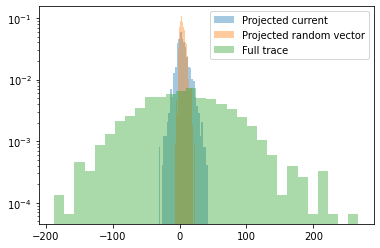

the matrices which are being traced over are the following

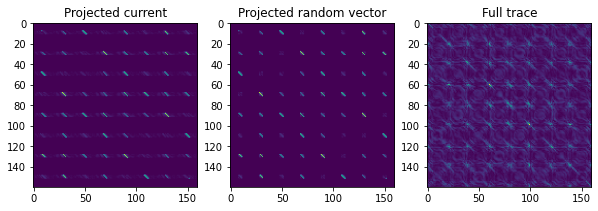

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kubo_lib2 import *
import time

Lx = 10
Ly = 2
sample = 2
dV = 0.1
mu = 0.2

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=True, SCALE=3.5)
kub.DEBUG = False

TMIN = 0; TMAX = 100; NT = 50; tlist = np.linspace(TMIN, TMAX, NT)
cond = np.zeros(NT, dtype=complex)

for i in range(NT):
    t = tlist[i]
    U = evolve(kub, t)
    Ui = evolve(kub, -t)
    F = fermi(kub, mu)
    P = projector(kub)
    V = kub.Vb

    op = P@V@P@U@F@Ui
    cond[i] = np.trace(op)*kub.SCALE/dV
    
plt.plot(tlist, np.real(cond))
plt.plot(tlist, np.imag(cond))
plt.show()

# fig, axs = plt.subplots(1,2, figsize=(10,4))
# axs[0].imshow(np.real(V))
# axs[1].imshow(np.imag(V))

In [ ]:
Lx = 20
Ly = 2
sample = 4
dV = 0.1
mu = 0.2
t = 80

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=True, SCALE=3.5)
kub.DEBUG = False



U = evolve(kub, t)
Ui = evolve(kub, -t)
F = fermi(kub, mu)
P = projector(kub)
V = kub.Vb

op1 = P@V@P@U@F@Ui*kub.SCALE/dV
op2 = P@V@P@U@F@Ui@P*kub.SCALE/dV
op3 = Ui@P@V@P@U@F*kub.SCALE/dV
cond1 = np.real(np.trace(op1))
cond2 = np.real(np.trace(op2))
cond3 = np.real(np.trace(op3))
print(cond1, cond2, cond3)

NR = 1000
condR1 = np.zeros(NR, dtype=complex)
condR2 = np.zeros(NR, dtype=complex)
condR3 = np.zeros(NR, dtype=complex)
for i in range(NR):
    rand = (np.random.random(kub.N) - 0.5)*np.sqrt(12)
    
    condR1[i] = rand.transpose().conjugate()@op1@rand
    condR2[i] = rand.transpose().conjugate()@op2@rand
    condR3[i] = rand.transpose().conjugate()@op3@rand
    
print(np.mean(condR1), np.mean(condR2), np.mean(condR3))
print(np.std(np.real(condR1)), np.std(np.real(condR2)), np.std(np.real(condR3)))
plt.hist(np.real(condR1), bins=30, alpha=0.4, density=True, label="Projected current")
plt.hist(np.real(condR2), bins=30, alpha=0.4, density=True, label="Projected random vector")
plt.hist(np.real(condR3), bins=30, alpha=0.4, density=True, label="Full trace")
plt.yscale('log')
plt.legend()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(10,4))
axs[0].imshow(np.abs(op1))
axs[1].imshow(np.abs(op2))
axs[2].imshow(np.abs(op3))
axs[0].set_title("Projected current")
axs[1].set_title("Projected random vector")
axs[2].set_title("Full trace")
plt.show()

# João Pinho

In [ ]:
kub = kubo()

sample = 250
Lx = 2000 + sample
dV = 0.1
SCALE = 2.1
kub.set_1DTB(Lx,sample,dV, SCALE=SCALE)


mu = 0.0
TMIN = 0; TMAX = 2000; NT = 1000
tlist = np.linspace(TMIN, TMAX, NT)


site_i = [Lx//2, 0,0]
site_j = [Lx//2+1, 0,0]

cond_bond = np.real(kub.kubo_bond(tlist, mu, site_i, site_j,0)/dV)


plt.plot(tlist, cond_bond,'-') 
plt.show()

In [ ]:

vmin = 100
vmax = 520
plt.plot(tlist[vmin:vmax], cond_bond[vmin:vmax],'-') 
plt.show()

# Test new Hamiltonian operator - periodic boundary conditions


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kubo_lib2 import *
import time

Lx = 16
Ly = 2
sample = 2
dV = 0.0

kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=False, PBC=True, SCALE=1)

psi = np.zeros([Lx, Ly, 4])
psi += 1
psi1 = psi*0.0
factors = [1 for i in range(len(kub.bonds))]

kub.hamiltonian_g(psi1, psi, kub.bonds, kub.offsets, factors)
# kub.hamiltonian_g(psi, psi1, kub.bonds, kub.offsets, factors)

# If PBC are well implemented, then a translation invariant Hamiltonian
# applied to a uniform vector should return a uniform vector
variance = np.var(psi1)
print(variance)


# Test time evolution with new Hamiltonian
Assuming time independent Hamiltonian

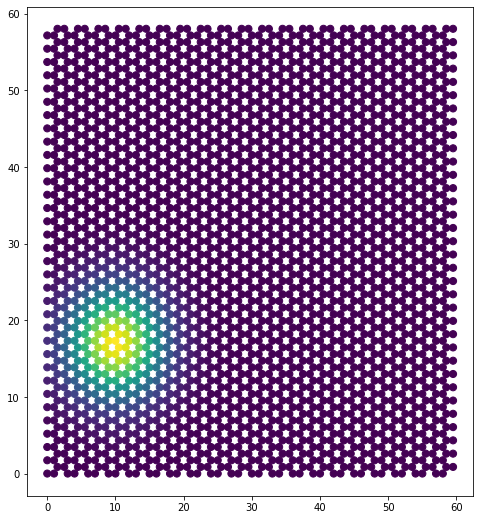

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from kubo_lib2 import *
import time
from IPython.display import HTML



Lx = 20
Ly = 34
No = 4
sample = 2
dV = 0.9


kub = kubo()
kub.set_graphene_nanoribbon(Lx, Ly, sample, dV, calc=False, PBC=True)

NT = 200
dt = 2
Ncheb = 30
psit = np.zeros([Lx, Ly, 4, NT], dtype=complex)

X = np.zeros([Lx, Ly, No])
Y = np.zeros([Lx, Ly, No])
for x in range(Lx):
    for y in range(Ly):
        for o in range(No):
            r = x*kub.primitives[0] + y*kub.primitives[1] + kub.orb_pos[o]
            X[x,y,o] = r[0]
            Y[x,y,o] = r[1]
            s = 5
            
            
            fx = np.exp(-0.5*(r[0]-Lx/2)**2/s**2)*np.exp(-1j*r[0]*0)
            fy = np.exp(-0.5*(r[1]-Ly/2)**2/s**2)*np.exp(1j*r[1]*0)
            f = fx*fy
            
            psit[x,y,o,0] = f
            
for i in range(NT-1):
    # kpm_time(kub, psit[:,:,:,i+1], psit[:,:,:,i], dt, Ncheb)
    kpm_time_g(kub, psit[:,:,:,i+1], psit[:,:,:,i], dt, Ncheb)
    
fig = plt.figure(figsize=(8,9))
scat = plt.scatter(X.flatten(),Y.flatten(), c=np.abs(psit[:,:,:,0].flatten()), s=50, cmap='viridis', vmin=0, vmax=1)
plt.show()

In [ ]:

matplotlib.rcParams['animation.embed_limit'] = 100

def update_plot(t, data, scat):
    scat.set_array(data[:,t])
    return scat,

cf = np.zeros([kub.N, NT])
for t in range(NT):
    cf[:,t] = np.real(psit[:,:,:,t].flatten())

frames = range(NT)
fig = plt.figure(figsize=(8,9))
scat = plt.scatter(X.flatten(),Y.flatten(), c=np.abs(psit[:,:,:,0].flatten()), s=50, cmap='viridis', vmin=0, vmax=1)

ani = animation.FuncAnimation(fig, update_plot, frames=frames, fargs=(cf, scat))

html = HTML(ani.to_jshtml())

In [ ]:
html

# Time evolution with time-dependent Hamiltonian
Testing exact time-evolution vs approximate

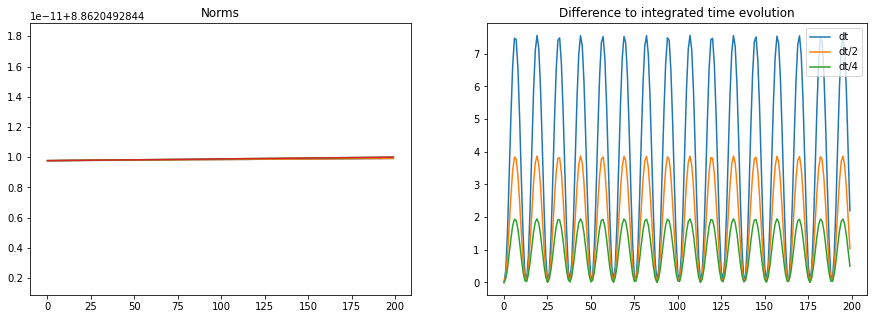

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from kubo_lib2 import *
import time
from IPython.display import HTML

# Time evolution assuming the Hamiltonian is constant along each time chunk dt
def fact(self, args):
    E = args[0]
    t = args[1]
    
    NB = len(self.offsets)
    component = np.zeros(NB)
    for i in range(NB):
        offset = self.offsets[i]
        
        o2 = offset[2]
        o1 = offset[3]
        dr  = offset[0]*self.primitives[0]
        dr += offset[1]*self.primitives[1]
        dr += self.orb_pos[o2] - self.orb_pos[o1]
        
        component[i] = dr@E
    
    return np.exp(1j*t*component)

# Time evolution assuming the Hamiltonian commutes across different times
def fact_exact(self, args):
    E  = args[0]
    t  = args[1]
    dt = args[2]
    
    NB = len(self.offsets)
    factors = np.zeros(NB, dtype=complex)
    for i in range(NB):
        offset = self.offsets[i]
        
        o2 = offset[2]
        o1 = offset[3]
        dr  = offset[0]*self.primitives[0]
        dr += offset[1]*self.primitives[1]
        dr += self.orb_pos[o2] - self.orb_pos[o1]
        
        delta = dr@E
        if np.abs(delta)<1e-10:
            factors[i] = 1
        else:
            integrated = (np.exp(1j*dt*delta)-1)/(1j*dt*delta)
            factors[i] = np.exp(delta*1j*t)*integrated
        
    
    return factors



In [ ]:
Lx = 30
Ly = 30
No = 1
sample = 2
dV = 0.0


kub = kubo()
kub.set_square(Lx, Ly, sample, dV, calc=False, PBC=True)

NT = 200
dt = 1
tlist = np.array([i*dt for i in range(NT)])

# starting wave vector
psi0 = np.zeros([Lx, Ly, No], dtype=complex)

X = np.zeros([Lx, Ly, No])
Y = np.zeros([Lx, Ly, No])
for x in range(Lx):
    for y in range(Ly):
        for o in range(No):
            r = x*kub.primitives[0] + y*kub.primitives[1] + kub.orb_pos[o]
            X[x,y,o] = r[0]
            Y[x,y,o] = r[1]
            s = 5
            
            
            fx = np.exp(-0.5*(r[0]-Lx/2)**2/s**2)*np.exp(-1j*r[0]*0)
            fy = np.exp(-0.5*(r[1]-Ly/2)**2/s**2)*np.exp(1j*r[1]*0)
            f = fx*fy
            
            psi0[x,y,o] = f
    

In [ ]:
Ncheb = 30

psit    = np.zeros([Lx, Ly, No, NT], dtype=complex)
psit_IP = np.zeros([Lx, Ly, No, NT], dtype=complex) # in place

psit_1  = np.zeros([Lx, Ly, No, NT], dtype=complex)
psit_2  = np.zeros([Lx, Ly, No, NT], dtype=complex)
psit_3  = np.zeros([Lx, Ly, No, NT], dtype=complex)

psit[:,:,:,0] = psi0
psit_IP[:,:,:,0] = psi0
psit_1[:,:,:,0] = psi0
psit_2[:,:,:,0] = psi0
psit_3[:,:,:,0] = psi0

psi_inplace = psi0*1.0

E0 = 0.1
E = [E0, E0]
for i in range(NT-1):
    t = tlist[i]
    factors = factor_velgauge_t_exact(kub,[E, t, dt])
    factors2a = fact(kub,[E, t])
    factors2b = fact(kub,[E, t+dt/2])
    
    
    factors3a = fact(kub,[E, t+dt/4])
    factors3b = fact(kub,[E, t+3*dt/4])
    
    # Exact time evolution
    kpm_time_g(kub, psit[:,:,:,i+1], psit[:,:,:,i], dt, Ncheb, factors)
    
    factorsU = factor_velgauge_t_exact(kub, [E, t, dt])
    kpm_time_inplace_g(kub, psi_inplace, dt, Ncheb, factorsU)
    psit_IP[:,:,:,i+1] = psi_inplace*1.0
    
    
    # Approx time evolution
    kpm_time_g(kub, psit_1[:,:,:,i+1], psit_1[:,:,:,i], dt, Ncheb, factors2a)
    
    # Approx time evolution with half dt
    psi_temp = psi0*0.0
    kpm_time_g(kub,           psi_temp,  psit_2[:,:,:,i], dt/2, Ncheb, factors2a)
    kpm_time_g(kub,  psit_2[:,:,:,i+1],         psi_temp, dt/2, Ncheb, factors2b)
    
    # Approx time evolution with quarter dt
    psi_temp1 = psi0*0.0
    psi_temp2 = psi0*0.0
    psi_temp3 = psi0*0.0
    kpm_time_g(kub,          psi_temp1,  psit_3[:,:,:,i], dt/4, Ncheb, factors2a)
    kpm_time_g(kub,          psi_temp2,        psi_temp1, dt/4, Ncheb, factors3a)
    kpm_time_g(kub,          psi_temp3,        psi_temp2, dt/4, Ncheb, factors2b)
    kpm_time_g(kub,  psit_3[:,:,:,i+1],        psi_temp3, dt/4, Ncheb, factors3b)
    
    

In [ ]:
difs = np.zeros([NT, 3])
norm = np.zeros([NT, 4])

for i in range(NT):
    difs[i,0] = np.linalg.norm(psit[:,:,:,i] - psit_1[:,:,:,i])
    difs[i,1] = np.linalg.norm(psit[:,:,:,i] - psit_2[:,:,:,i])
    difs[i,2] = np.linalg.norm(psit[:,:,:,i] - psit_3[:,:,:,i])
    
    norm[i,0] = np.linalg.norm(  psit[:,:,:,i])
    norm[i,1] = np.linalg.norm(psit_1[:,:,:,i])
    norm[i,2] = np.linalg.norm(psit_2[:,:,:,i])
    norm[i,3] = np.linalg.norm(psit_2[:,:,:,i])

fig, axs = plt.subplots(1,2,figsize=(15,5))
for i in range(4):
    axs[0].plot(tlist, norm[:,i])
axs[0].set_title("Norms")

names = ["dt", "dt/2", "dt/4"]
for i in range(3):
    axs[1].plot(tlist, difs[:,i], label=names[i])
axs[1].legend()
axs[1].set_title("Difference to integrated time evolution")
    
plt.show()

In [ ]:
t = 97
fig, axs = plt.subplots(1,3,figsize=(15,5))

for i,psi in zip([0,1,2], [psit, psit_1, psit_2]):
    axs[i].scatter(X.flatten(),Y.flatten(), c=np.abs(psi[:,:,:,t].flatten()), s=80, cmap='viridis', vmin=0, vmax=1)
plt.show()

## Testing inplace time-evolution

In [ ]:
t = 20

fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].scatter(X.flatten(),Y.flatten(), c=np.abs(psit[:,:,:,t].flatten()), s=80, cmap='viridis', vmin=0, vmax=1)
axs[1].scatter(X.flatten(),Y.flatten(), c=np.abs(psit_IP[:,:,:,t].flatten()), s=80, cmap='viridis', vmin=0, vmax=1)
plt.show()

difs = np.zeros(NT)

for i in range(NT):
    difs[i] = np.linalg.norm(psit[:,:,:,i] - psit_IP[:,:,:,i])
    
plt.plot(tlist, difs)
plt.show()


In [ ]:

matplotlib.rcParams['animation.embed_limit'] = 100

def update_plot(t, data, scat):
    scat.set_array(data[:,t])
    return scat,

cf = np.zeros([kub.N, NT])
for t in range(NT):
    cf[:,t] = np.abs(psit[:,:,:,t].flatten())**2

frames = range(NT)
fig = plt.figure(figsize=(5,5))
scat = plt.scatter(X.flatten(),Y.flatten(), c=np.abs(psit[:,:,:,0].flatten()), s=80, cmap='viridis', vmin=0, vmax=1)

ani = animation.FuncAnimation(fig, update_plot, frames=frames, fargs=(cf, scat))

html = HTML(ani.to_jshtml())

In [ ]:
html

# average value of velocity PBC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kubo_lib2 import *
import time

Lx = 64
Ly = 4
No = 1
sample = 10
dV = 1


kub = kubo()
kub.set_square(Lx, Ly, sample, dV, calc=False, PBC=True)


NT = 3000
dt = 0.3
tlist = np.array([i*dt for i in range(NT)])

axis = 0
# NchebF = 6000
# NchebT = 20

# starting wave vector
# psi0 = np.zeros([Lx, Ly, No], dtype=complex)
# psi0[Lx//2, Ly//2, 0] = 1
# conds1 = velocity_vector(kub, tlist, mu, psi0, NchebF, NchebT, axis)

# psi0 = np.zeros([Lx, Ly, No], dtype=complex)
# psi0[Lx//2+1, Ly//2, 0] = 1
# conds2 = velocity_vector(kub, tlist, mu, psi0, NchebF, NchebT, axis)

# plt.plot(tlist, np.imag(conds1),'--')
# plt.plot(tlist, np.imag(conds2),'--')

# plt.plot(tlist, np.real(conds1))
# plt.plot(tlist, np.real(conds2))

In [ ]:
# total_cond = np.zeros([NT,3],dtype=complex)
# for xx in range(1):
#     print(xx)
#     for yy in range(Ly):
#         print(yy)
#         psi0 = np.zeros([Lx, Ly, No], dtype=complex)
#         psi0[xx,yy, 0] = 1
#         total_cond[:,0] += velocity_vector(kub, tlist, mu, psi0, NchebF, NchebT, axis)
#         total_cond[:,1] += velocity_vector(kub, tlist, mu, psi0, NchebF, NchebT//2, axis)
#         total_cond[:,2] += velocity_vector(kub, tlist, mu, psi0, NchebF//2, NchebT, axis)

In [ ]:
# kub.get_matrix_bonds()
# # M = get_hamiltonian_matrix(kub, [kub.E,100])
# # M = get_velocity_matrix(kub, [0,kub.E,90])
# M = get_integrated_hamiltonian_matrix(kub, [kub.E,0,100])

# fig, axs = plt.subplots(1,2,figsize=(13,7))
# axs[0].imshow(np.real(M))
# axs[1].imshow(np.imag(M))
# plt.show()

In [ ]:
# Compute Hamiltonian matrix
E0 = dV / sample
kub.E = [E0, 0.0]
T = np.pi*2/E0
TT = 16
dT = T/TT
print(T)


N = kub.N
print(N)
H0k = np.zeros([N,N,kub.NB], dtype=complex)
tlist = [[i*dT, (i+1)*dT] for i in range(TT)]
tlist += [
         [0,T],
         [T,2*T]]
NL = len(tlist)

kub.get_matrix_bonds()
Hint = [get_integrated_hamiltonian_matrix(kub, [kub.E, i[0], i[1]]) for i in tlist]
                
mu = 2

# Fermi operator
H0 = get_hamiltonian_matrix(kub, [kub.E,0])
# print("op",np.linalg.norm(f0 - f0.transpose().conjugate()))
vals, vecs = np.linalg.eigh(H0)
P = np.linalg.inv(vecs)
print("inverse",np.linalg.norm(P@vecs - np.eye(N)))
f0 = vecs@np.diag([fermi0(vals[i], mu/kub.SCALE) for i in range(N)])@P
print("op",np.linalg.norm(f0 - f0.transpose().conjugate()))
print(np.trace(f0))

In [ ]:
U = [np.zeros([N,N], dtype=complex) for i in tlist]
for i in range(NL):
    print(i,end="")
    vals, vecs = np.linalg.eigh(Hint[i])
    dt = tlist[i][1] - tlist[i][0]
    U[i] = vecs@np.diag(np.exp(1j*vals*kub.SCALE))@np.linalg.inv(vecs)

In [ ]:
dT = T/TT
NT = 100
axis = 0
tlist2 = np.array([i*dT for i in range(NT)])

conds = np.zeros(NT, dtype=complex)
evolve = np.eye(N, dtype=complex)
for i in range(NT):
    print(i,end="")
    t = i*dT
    V = get_local_velocity_matrix(kub, [axis, kub.E, t])
    # V = get_local_velocity_matrix_const(kub, [axis, kub.E, t])
    # V = get_proj_velocity2(kub, [axis, kub.E, t])
    
    conds[i] = np.trace(f0@evolve@V@evolve.transpose().conjugate())
    
    evolve = U[i%TT]@evolve

In [ ]:
plt.plot(tlist2, np.real(conds))
plt.plot(tlist2, np.imag(conds))

In [ ]:
plt.plot(tlist2, np.real(conds))
plt.plot(tlist2, np.imag(conds))

In [ ]:
plt.plot(tlist2, np.real(conds))
plt.plot(tlist2, np.imag(conds))

In [ ]:
psi0 = np.zeros([Lx,Ly,No],dtype=complex)
psi0[Lx//2, Ly//2, 0] = 1

psi1 = de_linearize(kub,(U[3]@(U[2]@(U[1]@(U[0]@linearize(kub,psi0))))))
psi2 = de_linearize(kub,U[-1]@linearize(kub,psi0))
psi3 = de_linearize(kub,U[-2]@linearize(kub,psi0))

print(np.sum(np.abs(psi1)**2))
print(np.sum(np.abs(psi2)**2))
print(np.sum(np.abs(psi3)**2))
fig, axs = plt.subplots(1,3,figsize=(10,5))
axs[0].imshow(np.real(psi1))
axs[1].imshow(np.real(psi2))
axs[2].imshow(np.real(psi3))
